## Small bank entry  rates 

This notebook provides details on the figures and computations in the Center For Research on the Wisconsin Economy (CROWE) data brief \#1, "The Dodd-Frank Act and Small Bank Creation." 

We analyze small-bank (less than $10 bil in assets) entry for the U.S. economy. 

### Files needed 
* entry_exit_2019.xlsx
* call_reports_WI.csv 

In [1]:
import pandas as pd                    # for data handling
import numpy as np                     # for numerical methods and data structures
import matplotlib.pyplot as plt        # for plotting
import pandas_datareader.data as web
import datetime
import patsy                           # provides a syntax for specifying models  
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas

In [2]:
# Data from Kuan Liu used in Liu (2019)
data = pd.read_excel('entry_exit_2019.xlsx')
data = data[data.year != 1976]                    # 1976 does not have complete data
data.head(2)

,year,num_obs_year,num_entry,num_endenovo,num_acquier,num_enmerger,num_exit,num_target,num_exmerger,num_merger,num_exfail,ex_rate,en_rate,merger_rate,exfail_rate,exmerger_rate,endenovo_rate,num_megerplusfailuer,merger_fail_rate
1,1977,14393,164,144,95,4,166.0,153.0,153.0,248.0,13.0,0.011531,0.011392,0.017227,0.000903,0.010628,0.010003,261.0,0.018130
2,1978,14368,149,124,83,3,174.0,166.0,166.0,249.0,8.0,0.012089,0.010352,0.017300,0.000556,0.011533,0.008615,257.0,0.017856


Let's plot the data. This figure replicates figure 1 in Liu (2019).

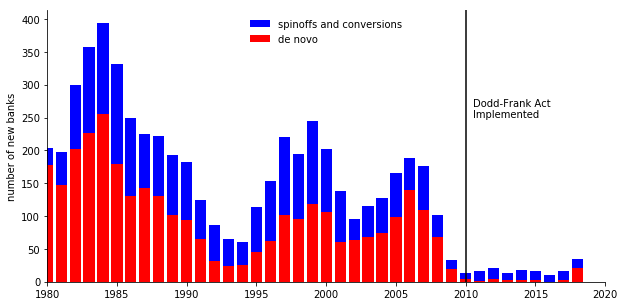

In [3]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(data.year, data.num_entry, color='blue', alpha=1, label='spinoffs and conversions')      
ax.bar(data.year, data.num_endenovo, color='red', alpha=1, label='de novo')

ax.axvline(x=2010, color = 'black')
ax.text(2010.5, 250, 'Dodd-Frank Act\nImplemented')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('number of new banks')
ax.legend(frameon = False)

# Restrict the figure to only show 1980 onward.
plt.xlim((1980, 2020))

plt.show()

In [4]:
# A few summary statistics for the draft
pre_dodd = data[(data.year>1980) & (data.year<2010)]
post_dodd = data[(data.year>=2010) & (data.year<=2018)]

all_avg_entry_8009 = pre_dodd['num_entry'].mean()
all_avg_entry_1018 = post_dodd['num_entry'].mean()

alldn_avg_entry_8009 = pre_dodd['num_endenovo'].mean()
alldn_avg_entry_1018 = post_dodd['num_endenovo'].mean()


print('avg. total entries per year:', all_avg_entry_8009,',', all_avg_entry_1018)
print('avg. de novo entries per year:', alldn_avg_entry_8009, ',', alldn_avg_entry_1018)
print('de novo share of total:', alldn_avg_entry_8009/all_avg_entry_8009,',', alldn_avg_entry_1018/all_avg_entry_1018)
print('number of total entries:', pre_dodd['num_entry'].sum(), ',', post_dodd['num_entry'].sum())
print('number of de novo entries:', pre_dodd['num_endenovo'].sum(), ',', post_dodd['num_endenovo'].sum())

avg. total entries per year: 181.27586206896552 , 17.666666666666668
avg. de novo entries per year: 103.03448275862068 , 4.222222222222222
de novo share of total: 0.5683850104622408 , 0.2389937106918239
number of total entries: 5257 , 159
number of de novo entries: 2988 , 38


## Entry vs. GDP growth
That's a striking figure. Is it all the fault of Dodd-Frank? The United States experienced a very deep recession in 2008--09 and interest rates (which are a proxy for return on bank assets) have been historically low. Let's look into these other drivers of bank entry. 

Let's start by getting some data from FRED.

In [5]:
# Use the FRED api to retreive real GDP and then compute the growth rate.
start = datetime.datetime(1979, 1, 1)
end = datetime.datetime(2018, 1, 1)

gdp = web.DataReader('GDPCA', 'fred', start, end)
gdp['growth'] = gdp['GDPCA'].pct_change()*100

I want to plot the pre- and post-DFA data in different colors to look for patterns. 

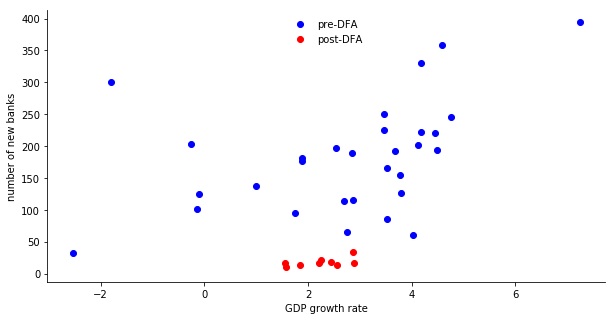

In [6]:
fig, ax = plt.subplots(figsize=(10,5))

# Pre-DFA data
x = gdp[(gdp.index > datetime.datetime(1979,1,1)) & (gdp.index < datetime.datetime(2010,1,1))]
y = data[(data.year > 1979) & (data.year<2010)]
ax.scatter(x.growth, y.num_entry, color='blue', alpha=1, label = 'pre-DFA')

# Post-DFA data
xx = gdp[gdp.index > datetime.datetime(2009,1,1)]
yy = data[data.year > 2009]
ax.scatter(xx.growth, yy.num_entry, color='red', alpha=1, label = 'post-DFA')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('number of new banks')
ax.set_xlabel('GDP growth rate')

ax.legend(frameon = False, loc='upper center', ncol=1)

plt.show()


## Entry vs. Fed funds rate
Compared to previous years the post-DFA entry rates are much lower than years with similar GDP growth rates. Post-DFA entry is abnormally low given the GDP growth rate. 

Let's now look at interest rates. We will use the Federal funds rate --- again, from FRED.

In [7]:
# The fed funds rate from FRED comes at a daily frequency. 
ffr = web.DataReader('FEDFUNDS', 'fred', start, end)
ffr = ffr.resample('y').mean()      # make the data annual by averaging

Same color scheme, for the same reasons, as the GDP growth rate figure.

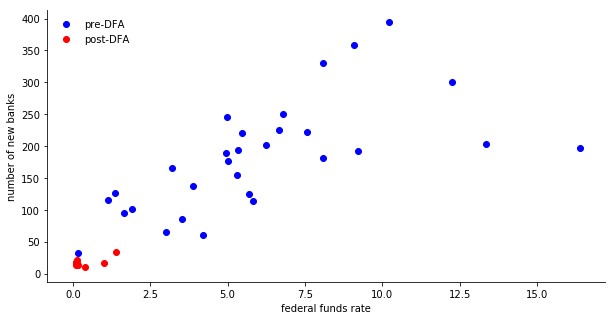

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

# Pre-DFA data
x = ffr[(ffr.index > datetime.datetime(1979,12,31)) & (ffr.index < datetime.datetime(2010,1,1))]
y = data[ (data.year > 1979) & (y.year < 2010)]
ax.scatter(x.FEDFUNDS, y.num_entry, color='blue', alpha=1, label='pre-DFA')

xx = ffr[ffr.index > datetime.datetime(2010,1,1)]
yy = data[data.year > 2009]

ax.scatter(xx.FEDFUNDS, yy.num_entry, color='red', alpha=1, label='post-DFA')

ax.legend(frameon = False, loc='upper left', ncol=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('number of new banks')
ax.set_xlabel('federal funds rate')

plt.show()

The entry data look less like outliers in this regard, although the more recent data points (as we move away from FFR==0) are lower than in past years.

## Predict post-DF entry

Let's use a simple model to try and predict total entry based on the GDP growth rate and the fed funds rate. I suspect we could do better with a more complicated model...

The idea is to estimate the model on the pre-DFA data and use it to predict the post-DFA entry rates. Comparing the predicted entry to the observed entry gives us a sense of much missing entry we observe.

In [9]:
# Create a data set with ffr, gdp growth and entry. 
gdp['year'] = gdp.index.year
ffr['year'] = ffr.index.year
data_all = pd.merge(left=ffr,      right=gdp, right_on='year', left_on='year')
data_all = pd.merge(left=data_all, right=data, left_on='year', right_on='year')

# Drop pre-1980, keep the variables we need
data_all = data_all[data_all.year > 1979]
data_all = data_all[['year', 'FEDFUNDS', 'num_entry', 'growth']]
print(data_all.head(2),'\n')
print(data_all.info())

   year   FEDFUNDS  num_entry    growth
1  1980  13.355833        204 -0.256752
2  1981  16.378333        197  2.537719 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 1 to 39
Data columns (total 4 columns):
year         39 non-null int64
FEDFUNDS     39 non-null float64
num_entry    39 non-null int64
growth       39 non-null float64
dtypes: float64(2), int64(2)
memory usage: 1.5 KB
None


### Estimate the model on the pre-DFA data: OLS
Start with a simple OLS model. 

In [10]:
res = smf.ols('num_entry ~ FEDFUNDS + growth', data=data_all[data_all.year<2010]).fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              num_entry   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     8.407
Date:                Fri, 31 May 2019   Prob (F-statistic):            0.00145
Time:                        11:16:15   Log-Likelihood:                -163.38
No. Observations:                  30   AIC:                             332.8
Df Residuals:                      27   BIC:                             337.0
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.8476     28.145      1.771      0.0

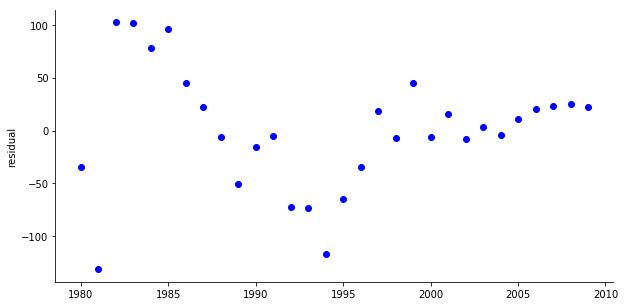

In [11]:
# Add the residuals to the data and plot them.
data_all['resids'] = res.resid
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(data_all[data_all.year<2010].year, data_all[data_all.year<2010].resids, color='blue')

ax.set_ylabel('residual')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

### Estimate the model on the pre-DFA data: GLSAR
Looks like some serial correlation in the error term. Let's model that as an AR process and run a GLSAR model.

In [12]:
# I do not think the GLSAR model is directly callable from the formulas api, so I create the design matrices first.
endog, exog = patsy.dmatrices('num_entry ~ FEDFUNDS + growth', data_all[data_all.year<2010])
mod3 = sm.GLSAR(endog, exog, rho=4)
res3 = mod3.iterative_fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:              num_entry   R-squared:                       0.612
Model:                          GLSAR   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     18.16
Date:                Fri, 31 May 2019   Prob (F-statistic):           1.85e-05
Time:                        11:16:15   Log-Likelihood:                -124.45
No. Observations:                  26   AIC:                             254.9
Df Residuals:                      23   BIC:                             258.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     60.7570     20.362      2.984      0.007      18.636     102.879
FEDFUNDS      18.0552      3.445      5.241      0.000      10.928      25.182
growth         4.5888      4.495      1.021      0.318      -4.709      13.887
==============================================================================
Omnibus:                        0.395   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.366
Skew:                          -0.250   Prob(JB):                        0.833
Kurtosis:                       2.706   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Below are the error term AR coefficients.

In [13]:
mod3.rho

array([ 0.77207524, -0.28723858,  0.03259504, -0.15351329])

### Use the estimated model to make predictions
Now we can use the models to create predictions for the post-DFA period. 

In [14]:
# The post-DFA data set
pred_data = data_all[data_all.year>=2010][['year', 'FEDFUNDS', 'growth', 'num_entry']]

# ols predicitions
pred_data.loc[:, 'pred'] = res.predict(pred_data)

# glas predictions(takes a bit more work...)
endogp, exogp = patsy.dmatrices('num_entry ~ FEDFUNDS + growth', data_all[data_all.year>=2010])
pred_data.loc[:, 'pred_glsar'] = pd.Series(res3.predict(exogp), index = [31, 32, 33, 34, 35, 36, 37, 38, 39])

pred_data.head(1)

,year,FEDFUNDS,growth,num_entry,pred,pred_glsar
31,2010,0.175,2.563767,13,94.386713,75.68138


In [15]:
# Set up the fitted values for plotting
fitted = pd.DataFrame({'fitted_vals': res3.fittedvalues})
fitted.index =  data_all[data_all.year<2010]['year']

In [16]:
print('predicted bank entry:', pred_data['pred_glsar'].sum())
print('this is', post_dodd['num_entry'].sum()/pred_data['pred_glsar'].sum()*100, 'of the observed' )

predicted bank entry: 703.5594560090683
this is 22.599369341423596 of the observed


## Add the predictions to the plot

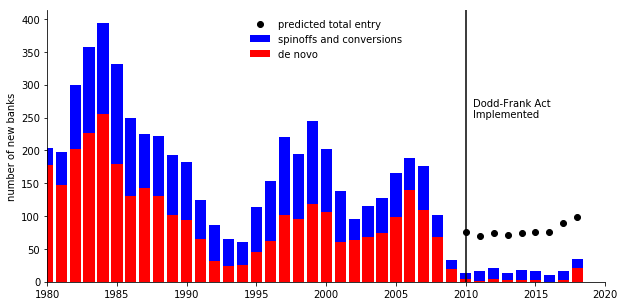

In [17]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(data.year, data.num_entry, color='blue',  label='spinoffs and conversions', zorder = 1)      # bar(x labels, )
ax.bar(data.year, data.num_endenovo, color='red', label='de novo', zorder = 2)

ax.scatter(pred_data.year, pred_data.pred_glsar, color='black', label='predicted total entry', zorder=3)
# ax.scatter(fitted.index, fitted.fitted_vals, color='black', label='in-sample fit', zorder=10, marker='*')

ax.axvline(x=2010, color = 'black')
ax.text(2010.5, 250, 'Dodd-Frank Act\nImplemented')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('number of new banks')
ax.legend(frameon = False)

plt.xlim((1980, 2020))

fig.savefig('agg_entry.pdf', bbox_inches='tight')

plt.show()

## Wisconsin entry 
How much of this entry is in Wisconsin? A preliminary look. These data are from Kuan Liu. See Liu (2009) for details. 

In [18]:
to_keep = ['entry_ind', 'date', 'year', 'bank_id', 'name', 'date_est', 'type', 'city']
wi_data = pd.read_csv('call_reports_WI.csv', low_memory=False, usecols=to_keep)

In [19]:
wi_entry = wi_data[['year', 'entry_ind']].groupby('year').sum()
wi_all = wi_data[['year', 'bank_id']].groupby('year').count()

In [20]:
wi_avg_entry_8009 = wi_entry[(2010 > wi_entry.index) & (wi_entry.index > 1979)].mean()
wi_avg_entry_1018 = wi_entry[(2010 <= wi_entry.index) & (wi_entry.index <= 2018)].mean()

In [21]:
wi_share_post = wi_avg_entry_1018/all_avg_entry_1018*100
wi_share_pre = wi_avg_entry_8009/all_avg_entry_8009*100

print('share of bank entry in wisconsin:', wi_share_pre.values, ',', wi_share_post.values)
print('missing entry in wisconsin:', wi_share_pre.values/100*545)

share of bank entry in wisconsin: [1.32394902] , [1.25786164]
missing entry in wisconsin: [7.21552216]


In [22]:
print('number of small banks in wi in 2009:', wi_all.loc[2009].values)

number of small banks in wi in 2009: [245]
